Main goal of this notebook is to use the google earth engine to identify and create features that represent the shoreline/waterline of the wetland projects based on different parameters like NDWI, VV and VH backscatter, and individual mutispectral bands

In [ ]:
## before anything you need to visit the site below and make sure you have a google earth engine account
## this is so you can access Sentinel-1 GRD and Sentinel-2 TOA and SR products, as well as other sensor packages and data types

## visit the below website below to setup an earth engine account, enable a cloud project, and enable the ee API 
## https://developers.google.com/earth-engine/cloud/earthengine_cloud_project_setup#get-access-to-earth-engine

In [1]:
import ee
import geemap
import geemap.colormaps as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [ ]:
## only need to run this once
## after authenticating with google earth engine you will only need to initialize each session

## https://developers.google.com/earth-engine/guides/auth
ee.Authenticate()

In [2]:
## init ee cloud project you made during initial setup
ee.Initialize(project = 'ee-claycaldgsl') ##enter your project name here as a string to initialize exchanges with ee api

# Some functions for a bit easier mapping
super simple for now, might make them better later

In [3]:
## Function to add RGB images to the map.
def add_rgb_to_map(image, map_object, coll):

    date = ee.Date(image.get('date')).format('YYYY-MM-dd').getInfo()
    for band in coll.first().bandNames().getInfo(): ## all images if small enough image collection
        map_object.addLayer(image, {'min': 0, 'max': 2000, 'bands': ['B4', 'B3', 'B2']}, f'{date}_rgb')

## Function to add spectral indices images to the map.
def add_ind_to_map(image, map_object, coll):

    date = ee.Date(image.get('date')).format('YYYY-MM-dd').getInfo()
    for band in coll.first().bandNames().getInfo():
        if band =='NDWI':
            map_object.addLayer(image, {'min': -1, 'max': 1, 'bands': band, 'palette': ['00FFFF', '0000FF']}, f'{date}_{band}')
        elif band =='NDVI': 
            map_object.addLayer(image, {'min': -1, 'max': 1, 'bands': band, 'palette': ['FF0000', '008000']}, f'{date}_{band}')

## Function to add spectral indices images to the map.
def add_sar_to_map(image, map_object, coll, target_band):

    date = ee.Date(image.get('date')).format('YYYY-MM-dd').getInfo()
    for band in coll.first().bandNames().getInfo():
        if band == target_band:
            map_object.addLayer(image, {'min': -50, 'max': 1, 'bands': band}, f'{date}_{band}')

In [4]:
## functiont to create three important and popular spectral indices
## ndvi = Normalized Difference Vegetation Index, good for vegetation health and cover
## ndwi = Normalized Difference Water Index, good for identifying water bodies and mositure in surface
def s2_10m_target_indices(image):
    ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
    ndwi = image.normalizedDifference(['B3', 'B8']).rename('NDWI')
    return image.addBands([ndvi, ndwi])

## collects sentinel-1 GRD (radar, no phase) and Sentinel-2 SR (multispectral, adjusted for top of atmosphere reflectance)
def get_sentinel_imagery(aoi, start_date, end_date, s2_cloud_cov, orbit):
    ## Sentinel-1 ImageCollection
    s1_VV = (ee.ImageCollection('COPERNICUS/S1_GRD')
               .filterBounds(aoi)
               .filterDate(ee.Date(start_date), ee.Date(end_date))
               .map(lambda img: img.set('date', ee.Date(img.date()).format('YYYYMMdd')))
               .filter(ee.Filter.eq('orbitProperties_pass', orbit))
               .select(['VV'])
               .sort('date')
    )

    s1_VH = (ee.ImageCollection('COPERNICUS/S1_GRD')
               .filterBounds(aoi)
               .filterDate(ee.Date(start_date), ee.Date(end_date))
               .map(lambda img: img.set('date', ee.Date(img.date()).format('YYYYMMdd')))
               .filter(ee.Filter.eq('orbitProperties_pass', orbit))
               .select(['VH'])
               .sort('date')
    )

    ## Clip all images in the collection to the AOI
    s1_VV = s1_VV.map(lambda img: img.clip(aoi))
    s1_VH = s1_VH.map(lambda img:img.clip(aoi))
    ## Sentinel-2 Surface Reflectance Harmonized ImageCollection
    s2_10m = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
               .filterBounds(aoi)
               .filterDate(ee.Date(start_date), ee.Date(end_date))
               .map(lambda img: img.set('date', ee.Date(img.date()).format('YYYYMMdd')))
               .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', s2_cloud_cov))
               .sort('date')
               .select(['B2', 'B3', 'B4', 'B8'])
    )
    ## Clip all images in the collection to the AOI
    s2_10m = s2_10m.map(lambda img: img.clip(aoi))
    ## Apply indices to the Sentinel-2 images
    s2_10m_ndvi = s2_10m.map(s2_10m_target_indices).select(['NDVI'])
    s2_10m_ndwi = s2_10m.map(s2_10m_target_indices).select(['NDWI'])
    
    return s1_VV, s1_VH, s2_10m, s2_10m_ndvi, s2_10m_ndwi


In [5]:
## fucntion to get the date of each image in the image collection
def get_date(image):
    return ee.Feature(None, {'date': image.date().format('YYYY-MM-dd')})

In [6]:
def export_image_to_drive(collection, collname, image, index):
    # Define the description for the export, incorporating the index for uniqueness

    if collname == 's1_VV':
        description = f"s1_VV_{index}"
    elif collname == 's1_VH':
        description = f's1_VH_{index}'
    elif collname == 'rgb':
        description = f's2_10m_{index}'
    elif collname == 'ndvi':
        description = f's2_10m_ndvi_{index}'
    else:
        description = f's2_10m_ndwi_{index}'

    # Setup the export task
    task = ee.batch.Export.image.toDrive(
        image=image,
        description=description,
        region=aoi,  # Make sure the geometry is defined earlier
        fileFormat='GeoTIFF',
        scale = 10
    )
    task.start()
    print(f'Exporting {description} to Drive...')

def export_all_images(collection, collname):
    image_list = collection.toList(collection.size())  # Convert ImageCollection to List
    num_images = image_list.size().getInfo()  # Get the number of images

    if collname[:2] == 's1':
        for i, date in enumerate(s1_date_list):
            image = ee.Image(image_list.get(i))
            export_image_to_drive(collection, collname, image, date[:10])

    else:
        for i, date in enumerate(s2_date_list):
            image = ee.Image(image_list.get(i))
            export_image_to_drive(collection, collname, image, date[:10])

In [7]:
# Define a function to get histogram of NDWI for each image
def get_histogram(image, scale, bucket_num, band_name):
    """
    Used to create ndwi histograms for the imagery

    image = ee.Image
        NDWI image to determine the shoreline from
    scale = int
        scale to estimate the histogram from, typically 10 to match the resolution of the RGB imagery
    bucket_num = int
        number of buckets to put the data into for histogram
    band_name = str
        the name of your target band in the image
    """


    # Reduce the image to get a histogram over the region of interest (ROI)
    hist = image.reduceRegion(
        reducer=ee.Reducer.histogram(maxBuckets=bucket_num),  # Adjust the number of buckets as needed
        geometry=aoi,
        scale=scale,  # Adjust based on image resolution
        maxPixels=1e8
    )
    
    # Get the histogram data for NDWI
    histogram = ee.Dictionary(hist.get(band_name)).getInfo() 
    
    return histogram

In [8]:
def otsu_trimodal_from_histogram(histogram):
    # Extract histogram and means from the provided NDWI histogram
    counts = np.array(histogram['histogram'])
    means = np.array(histogram['bucketMeans'])
    total = np.sum(counts)
    sum_values = np.sum(means * counts)
    overall_mean = sum_values / total
    size = len(means)

    # Define a function to compute the between-class variance (BSS)
    def compute_intervariance(i, k):
        # Compute for first region (A)
        aCounts = counts[:i]
        aCount = np.sum(aCounts)
        aMeans = means[:i]
        aMean = np.sum(aMeans * aCounts) / aCount if aCount != 0 else 0

        # Compute for second region (B)
        bCounts = counts[i:k]
        bCount = np.sum(bCounts)
        bMeans = means[i:k]
        bMean = np.sum(bMeans * bCounts) / bCount if bCount != 0 else 0

        # Compute for third region (C)
        cCounts = counts[k:]
        cCount = np.sum(cCounts)
        cMeans = means[k:]
        cMean = np.sum(cMeans * cCounts) / cCount if cCount != 0 else 0

        # Return combined BSS
        return aCount * (aMean - overall_mean) ** 2 + \
               bCount * (bMean - overall_mean) ** 2 + \
               cCount * (cMean - overall_mean) ** 2

    # Initialize an empty list for BSS values
    bss_values = []
    
    # Iterate through potential thresholds
    for i in range(1, size - 1):  # Start at 1, and stop before the last element
        for k in range(i + 1, size):  # Ensure k is always greater than i
            bss_values.append(compute_intervariance(i, k))

    # Convert BSS values to a NumPy array
    bss_array = np.array(bss_values)

    # Find indices of maximum BSS
    max_bss_index = np.argmax(bss_array)
    
    # Convert the flat index back to i and k values
    i_max = max_bss_index // (size - 1)
    k_max = max_bss_index % (size - 1)

    # Return corresponding means for the threshold
    return means[i_max], means[k_max]

In [9]:
def extract_shoreline(coll, datelist):
    shorelines = []
    smoothed_vectors = []

    image_list = coll.toList(coll.size())  # Convert ImageCollection to List
    for i, date in enumerate(datelist):
        im = ee.Image(image_list.get(i))
        hist = get_histogram(im, 10, 150, 'NDWI')
    
        t1, t2 = otsu_trimodal_from_histogram(hist)
        if t1 < t2:
            ndwi_thresh = [t1, t2]
        else:
            ndwi_thresh = [t2, t1]
        
        water_mask = im.lt(ee.Number(ndwi_thresh[0]))
        land_mask = im.gt(ee.Number(ndwi_thresh[1]))
        water_land_mask = water_mask.Not().add(land_mask).divide(2)
        shores = water_land_mask.updateMask(water_land_mask.gt(0.0))
    
        binary_mask = im.updateMask(im.gte(0.0)).mask()
        dilated_mask = binary_mask.focal_max(radius=10, units = 'meters')
        eroded_mask = binary_mask.focal_min(radius=10, units = 'meters')
        border_mask = dilated_mask.subtract(eroded_mask)
        shoreline = shores.updateMask(border_mask) ###should be shoreline

        shorelines.append(shoreline)  # shoreline
        
    return ee.ImageCollection(shorelines)

def extract_vegline(coll, datelist):
    veglines = []
    
    image_list = coll.toList(coll.size())  # Convert ImageCollection to List
    for i, date in enumerate(datelist):
        im = ee.Image(image_list.get(i))
        hist = get_histogram(im, 10, 150, 'NDVI')
    
        t1, t2 = otsu_trimodal_from_histogram(hist)
        if t1 < t2:
            ndvi_thresh = [t1, t2]
        else:
            ndvi_thresh = [t2, t1]
        
        fv_mask = im.lt(ee.Number(ndvi_thresh[0]))
        dv_mask = im.gt(ee.Number(ndvi_thresh[1]))
        veg_land_mask = fv_mask.Not().add(dv_mask).divide(2)
        veg = veg_land_mask.updateMask(veg_land_mask.gt(0.0))
    
        binary_mask = im.updateMask(im.gte(0.5)).mask()
        dilated_mask = binary_mask.focal_max(radius=10, units = 'meters')
        eroded_mask = binary_mask.focal_min(radius=10, units = 'meters')
        border_mask = dilated_mask.subtract(eroded_mask)
        vegline = veg.updateMask(border_mask) ###should be shoreline

        veglines.append(vegline)

    return ee.ImageCollection(veglines)


# Get area of interest

In [10]:
## interactive map for you to draw a polygon to signify your aoi

## Create a map centered at a specific location
m = geemap.Map(center=[20, 0], zoom=2, basemap='HYBRID')
## Add drawing tools
m.add_draw_control()
## Display the map
display(m)

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(child…

In [11]:
## Get the drawn features
draw_features = m.draw_features[0]
## Establish ee.Polygon from drawn area of interest to collect imagery
aoi = ee.Geometry.Polygon(draw_features.getInfo()['geometry']['coordinates'][0])

# Get Imagery

In [12]:
start_date = '2019-09-01' ## start date of search window
end_date = '2024-09-01' ## end date of search window
s2_cloud_cov = 10 ## percentage of clouds in sentinel-2 multispectral imagery, less means you see more surface
orbit = 'ASCENDING' ## orbit for imagery

collections = {}
for i in range(int(start_date[:4]), int(end_date[:4])):
    collections[f's1_VV_{i}_{i+1}'], collections[f's1_VH_{i}_{i+1}'], collections[f's2_10m_{i}_{i+1}'], collections[f's2_10m_ndvi_{i}_{i+1}'], collections[f's2_10m_ndwi_{i}_{i+1}'] = get_sentinel_imagery(aoi, f'{i}{start_date[4:]}', f'{i+1}{end_date[4:]}', s2_cloud_cov, orbit)

In [13]:
colls = []
for i, coll in enumerate(collections):
    if collections[coll].size().getInfo() != 0: # removes image collections that are empty
        colls.append(coll)

for i, coll in enumerate(colls):
    print(f'{i}: {coll}')

0: s1_VV_2019_2020
1: s1_VH_2019_2020
2: s2_10m_2019_2020
3: s2_10m_ndvi_2019_2020
4: s2_10m_ndwi_2019_2020
5: s1_VV_2020_2021
6: s1_VH_2020_2021
7: s2_10m_2020_2021
8: s2_10m_ndvi_2020_2021
9: s2_10m_ndwi_2020_2021
10: s1_VV_2021_2022
11: s1_VH_2021_2022
12: s2_10m_2021_2022
13: s2_10m_ndvi_2021_2022
14: s2_10m_ndwi_2021_2022
15: s1_VV_2022_2023
16: s1_VH_2022_2023
17: s2_10m_2022_2023
18: s2_10m_ndvi_2022_2023
19: s2_10m_ndwi_2022_2023
20: s1_VV_2023_2024
21: s1_VH_2023_2024
22: s2_10m_2023_2024
23: s2_10m_ndvi_2023_2024
24: s2_10m_ndwi_2023_2024


# Visualize Distribution of NDWI Values for Select Images

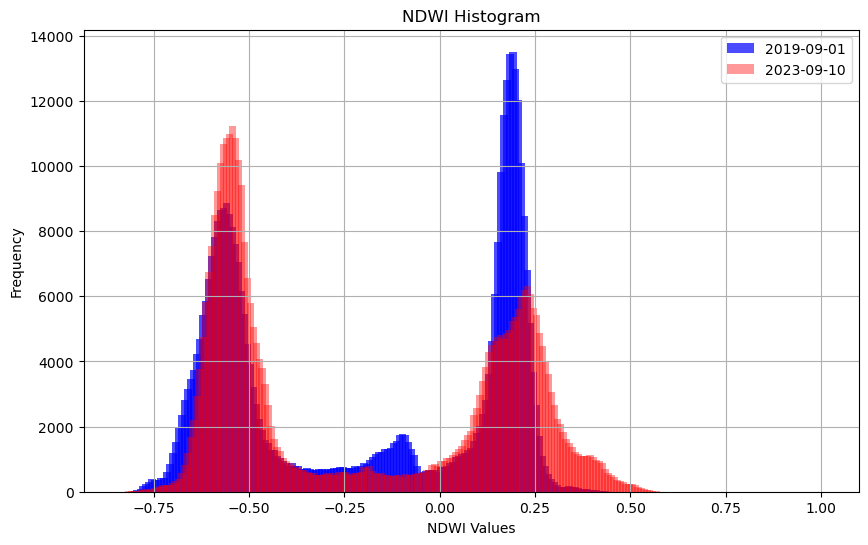

NDWI Thershold 1 2019-09-01= -0.4258747228906597
NDWI Thershold 2 2019-09-01= -0.27745010750452664
NDWI Thershold 1 2023-09-10= -0.4180332672663844
NDWI Thershold 2 2023-09-10= -0.722458314429626


In [14]:
# no mask

# all I need for segmenting images into coastlines would be
# Need to make this applicable for each image in image collection
# it will read in a specified band of a passed image collection, then segment it using Otsu's method
# It should create a new image collection of 
#   1) Water Bodies, 2) Land Bodies, 3) Shorelines
# those can then be used to measure horizontal changes in shoreline over time

# Get the first image in the collection (or map over the collection if needed)
s2_date_list = collections[colls[4]].map(get_date).aggregate_array('date').getInfo()
ndwi_image = collections[colls[4]].first()

ndwi_date = s2_date_list[0]
ndwi_histogram = get_histogram(ndwi_image, 10, 150, 'NDWI')

# Extract the histogram values for plotting
ndwi_values = ndwi_histogram['bucketMeans']
ndwi_counts = ndwi_histogram['histogram']


# second date
# Get the first image in the collection (or map over the collection if needed)
s2_date_list2 = collections[colls[24]].map(get_date).aggregate_array('date').getInfo()
ndwi_image2 = collections[colls[24]].first()

ndwi_date2 = s2_date_list2[0]
ndwi_histogram2 = get_histogram(ndwi_image2, 10, 150, 'NDWI')

# Extract the histogram values for plotting
ndwi_values2 = ndwi_histogram2['bucketMeans']
ndwi_counts2 = ndwi_histogram2['histogram']

# Plot the histogram using Matplotlib
plt.figure(figsize=(10, 6))
plt.bar(ndwi_values, ndwi_counts, width=0.02, color='blue', alpha=0.7, label = ndwi_date)
plt.bar(ndwi_values2, ndwi_counts2, width=0.02, color='red', alpha=0.4, label = ndwi_date2)
plt.title(f"NDWI Histogram")
plt.xlabel("NDWI Values")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

edge_i, edge_k = otsu_trimodal_from_histogram(ndwi_histogram)
print(f'NDWI Thershold 1 {ndwi_date}= {edge_i}')
print(f'NDWI Thershold 2 {ndwi_date}= {edge_k}')

if edge_i < edge_k:
    ndwi_thresh = [edge_i, edge_k]
else:
    ndwi_thresh = [edge_k, edge_i]

edge_i2, edge_k2 = otsu_trimodal_from_histogram(ndwi_histogram2)
print(f'NDWI Thershold 1 {ndwi_date2}= {edge_i2}')
print(f'NDWI Thershold 2 {ndwi_date2}= {edge_k2}')

if edge_i2 < edge_k2:
    ndwi_thresh2 = [edge_i2, edge_k2]
else:
    ndwi_thresh2 = [edge_k2, edge_i2]

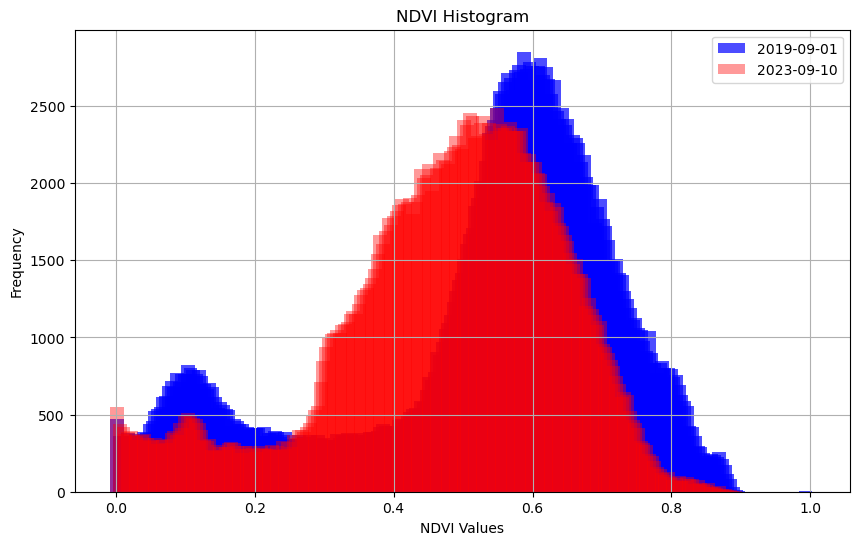

NDVI Thersholds for 2019-09-01 = [np.float64(0.2597491839993327), np.float64(0.28323345813552153)]
NDVI Thersholds for 2023-09-10 = [np.float64(0.23240658448855142), np.float64(0.4159627485324983)]


In [15]:
# no mask

# all I need for segmenting images into coastlines would be
# Need to make this applicable for each image in image collection
# it will read in a specified band of a passed image collection, then segment it using Otsu's method
# It should create a new image collection of 
#   1) Water Bodies, 0) Land Bodies, 3) Shorelines
# those can then be used to measure horizontal changes in shoreline over time

# Get the first image in the collection (or map over the collection if needed)
s2_date_list = collections[colls[3]].map(get_date).aggregate_array('date').getInfo()
ndvi_image = collections[colls[3]].first()
ndvi_image = ndvi_image.updateMask(ndvi_image.gte(0.0))     ### mask to remove the water and low vegetation areas

ndvi_date = s2_date_list[0]
ndvi_histogram = get_histogram(ndvi_image, 10, 150, 'NDVI')

# Extract the histogram values for plotting
ndvi_values = ndvi_histogram['bucketMeans']
ndvi_counts = ndvi_histogram['histogram']


# second date
# Get the first image in the collection (or map over the collection if needed)
s1_date_list2 = collections[colls[23]].map(get_date).aggregate_array('date').getInfo()
ndvi_image2 = collections[colls[23]].first()
ndvi_image2 = ndvi_image2.updateMask(ndvi_image2.gte(0.0))

ndvi_date2 = s1_date_list2[0]
ndvi_histogram2 = get_histogram(ndvi_image2, 10, 150, 'NDVI')

# Extract the histogram values for plotting
ndvi_values2 = ndvi_histogram2['bucketMeans']
ndvi_counts2 = ndvi_histogram2['histogram']

# Plot the histogram using Matplotlib
plt.figure(figsize=(10, 6))
plt.bar(ndvi_values, ndvi_counts, width=0.02, color='blue', alpha=0.7, label = ndvi_date)
plt.bar(ndvi_values2, ndvi_counts2, width=0.02, color='red', alpha=0.4, label = ndvi_date2)
plt.title(f"NDVI Histogram")
plt.xlabel("NDVI Values")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

edge_i, edge_k = otsu_trimodal_from_histogram(ndvi_histogram)
if edge_i < edge_k:
    ndvi_thresh = [edge_i, edge_k]
else:
    ndvi_thresh = [edge_k, edge_i]

edge_i2, edge_k2 = otsu_trimodal_from_histogram(ndvi_histogram2)
if edge_i2 < edge_k2:
    ndvi_thresh2 = [edge_i2, edge_k2]
else:
    ndvi_thresh2 = [edge_k2, edge_i2]

print(f'NDVI Thersholds for {ndvi_date} = {ndvi_thresh}')
print(f'NDVI Thersholds for {ndvi_date2} = {ndvi_thresh2}')

# Shoreline and Veg line detection based on Otsu Trimodal Thresholds

Get info of specific areas of information
- can be specific areas where change has occurred, in my application probably sediment enrichment
- (working) get a time series of NDVI and NDWI for the area delineated by the drawn aois and shoreline

In [16]:
## Create a map centered at a specific location
m = geemap.Map()
m.centerObject(aoi, 12)

# Add the original rgb image for context
m.addLayer(collections[colls[2]].first(), {'min': 0, 'max': 2000, 'bands': ['B4', 'B3', 'B2']}, f'{ndwi_date} RGB')


#draw the specific aois you want to get time series info from
# for now needs to be an area
# later will add stuff for transects
m.add_draw_control()
m.addLayerControl()
display(m)


Map(center=[29.934847935325628, -93.40679150000072], controls=(WidgetControl(options=['position', 'transparent…

In [17]:
# want to add another 
## Get the drawn features
drawn_features = m.draw_features

aois = ee.FeatureCollection(drawn_features)

sites = {}
for i, site in enumerate(drawn_features):
    sites[f'Site {i}'] = ee.Geometry.Polygon(site.getInfo()['geometry']['coordinates'][0])

In [18]:
# for coll in collections

###FIND A WAY TO CLIP THE RESULTS BELOW TO ONLY THE drawn_features###
# maybe use the polygons as well? Can give info about change in veg cover and land mass?

s2_date_list = collections[colls[19]].map(get_date).aggregate_array('date').getInfo()
shoreline_collection = extract_shoreline(coll = collections[colls[19]] , datelist =s2_date_list)
vegline_collection = extract_vegline(coll = collections[colls[18]], datelist = s2_date_list )

In [19]:
clipped_shores = shoreline_collection.map(lambda img: img.clip(aois))
clipped_veg = vegline_collection.map(lambda img: img.clip(aois))
clipped_rgb = collections[colls[17]].map(lambda img: img.clip(aois))

In [23]:
clipped_shores

In [20]:
maptest = geemap.Map()
maptest.centerObject(aoi, 12)

rgb_images = clipped_rgb.toList(clipped_rgb.size())
for i in range(clipped_rgb.size().getInfo()//5):
    image = ee.Image(rgb_images.get(i))
    add_rgb_to_map(image, maptest, clipped_rgb)

    shore_im = ee.Image(clipped_shores.toList(clipped_shores.size()).get(i))
    maptest.addLayer(shore_im, {}, f'{s2_date_list[i]} shore')

# maptest.add_draw_control()
# Display the map
maptest.addLayerControl()

## Display the map
display(maptest)

Map(center=[29.934847935325628, -93.40679150000072], controls=(WidgetControl(options=['position', 'transparent…

In [49]:
map_ts = geemap.Map()
map_ts.centerObject(aoi, 12)


# Visualize each image in the ImageCollection.
rgb_images = clipped_rgb.toList(clipped_rgb.size())
for i in range(clipped_rgb.size().getInfo()//5):
    image = ee.Image(rgb_images.get(i))
    add_rgb_to_map(image, map_ts, clipped_rgb)
    
    shore_im = ee.Image(clipped_shores.toList(clipped_shores.size()).get(i))
    map_ts.addLayer(shore_im, {'palette': 'black'}, f'{s2_date_list[i]} shore')

    veg_im = ee.Image(clipped_veg.toList(clipped_veg.size()).get(i))
    map_ts.addLayer(veg_im, {'palette': 'red'}, f'{s2_date_list[i]} veg')

# Display the map.
map_ts.addLayerControl(position = 'topright')
map_ts

Map(center=[29.93276375136176, -93.40541850000376], controls=(WidgetControl(options=['position', 'transparent_…

# Testing
- Get spatial statisitics from drawn_features, plot them in a time-series to show upper-value, lower-value, and mean-value for NDWI and NDVI. Will show evolution of vegetation cover and surface moisture from Sentinel-2
- Vectorize the shoreline? Need to get the horizontal changes in the identified shorelines between subsequent changes
- Once able to spatially estimate shoreline changes, use those to estimate area changes for the marsh creation sites. (Once the area is estiamted, the volumetric changes can be estimated using closmure phase corrected InSAR)

In [35]:
# Function to calculate statistics for NDVI and NDMI over AOIs
def extract_statistics(image, index_name):
    # Reduce the image over the AOIs using mean, max, and min reducers
    stats = image.select(index_name).reduceRegions(
        collection=aois,
        reducer=ee.Reducer.mean().combine(
            reducer2=ee.Reducer.minMax(),
            sharedInputs=True
        ),
        scale=10  # The scale at which to perform the reduction (meters)
    )
    
    # Add the date of the image as a property to each feature in the collection
    date = ee.Date(image.get('system:time_start')).format('YYYY-MM-dd')
    stats = stats.map(lambda f: f.set('date', date))
    
    return stats

def extract_statistics_from_collection(image_collection, index_name):
    # Map the extract_statistics function over the image collection
    stats_collection = image_collection.map(lambda img: extract_statistics(img, index_name)).flatten()

    # Convert the results to a list of dictionaries for export to Pandas
    stats_list = stats_collection.getInfo()['features']

    # Create a Pandas DataFrame from the list of dictionaries
    data = []
    for feature in stats_list:
        properties = feature['properties']
        data.append({
            'date': properties['date'],
            'aoi_id': properties.get('id', 'unknown'),  # Assuming AOI has an ID property
            f'{index_name}_mean': properties.get(f'{index_name}_mean'),
            f'{index_name}_min': properties.get(f'{index_name}_min'),
            f'{index_name}_max': properties.get(f'{index_name}_max')
        })

    df = pd.DataFrame(data)

    # Convert the date column to datetime
    df['date'] = pd.to_datetime(df['date'])

    # Sort the DataFrame by date
    df = df.sort_values(by='date')

    return df

In [65]:
# my function needs im_coll, index_name, and aoi

def extract_stats_from_aoi(image_collection, index_name, aoi):
    stats_ims = image_collection.map(lambda img: img.clip(aoi))
    stats_collection = image_collection.map(lambda img: extract_statistics(img, index_name)).flatten()
    statslist = stats_collection.getInfo()['features']

    data=[]
    for feature in statslist:
        properties = feature['properties']
        data.append({
            'date': properties['date'],
            # 'aoi_id': key,  # aois needs to be an input from drawn_features
            f'{index_name}_mean': properties['mean'],
            f'{index_name}_min': properties['min'],
            f'{index_name}_max': properties['max']
        })

    df = pd.DataFrame(data)

    # Convert the date column to datetime
    df['date'] = pd.to_datetime(df['date'])

    # Sort the DataFrame by date
    df = df.sort_values(by='date')

    return df

In [66]:
ndvi_df = extract_stats_from_aoi(collections[colls[23]], 'NDVI', sites['Site 2'])
ndwi_df = extract_stats_from_aoi(collections[colls[24]], 'NDWI', sites['Site 2'])

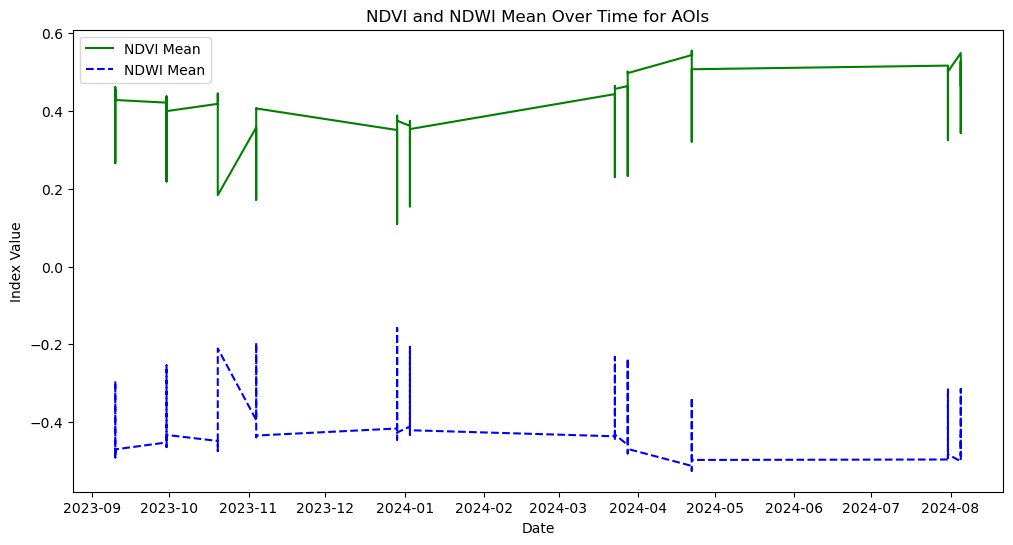

In [67]:
# Optional: Plotting the results
plt.figure(figsize=(12, 6))

# Plot NDVI statistics

plt.plot(ndvi_df['date'], ndvi_df['NDVI_mean'], label=f'NDVI Mean', color='green')

# Plot NDWI statistics
plt.plot(ndwi_df['date'], ndwi_df['NDWI_mean'], label=f'NDWI Mean', color='blue', linestyle='--')

plt.xlabel('Date')
plt.ylabel('Index Value')
plt.title('NDVI and NDWI Mean Over Time for AOIs')
plt.legend()
plt.show()

# Export Shoreline information

In [ ]:
# Export the shoreline vector as GeoJSON for use in QGIS or GDAL
task = ee.batch.Export.table.toDrive(
    collection=vector_shoreline,
    description='Shoreline_Export',
    fileFormat='GeoJSON',  # GeoJSON is well-supported in QGIS and GDAL
    fileNamePrefix='shoreline'
)

# Start the export task
task.start()
print("Shoreline extraction task started, check Google Earth Engine tasks for progress.")

In [ ]:
Export.image.toDrive({
    'image': first_edge_image,
    'description': 'Canny_Edges_Example',
    'scale': 10,  # Adjust the scale according to the dataset resolution
    'region': aoi,
    'maxPixels': 1e8
})